# ch04.05 Wave Net

* 날짜:
* 이름:

## 학습내용
    - Audio data에 대해 이해한다.
    - 머신러닝 방법으로 접근하여 문제를 해결해 본다.
    - 딥러닝 네트워크를 이용해 문제를 해결한다.
    - waveNet, yamNet 등 딥러닝 알고리즘을 적용한다.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys, os
sys.path.append('/content/drive/MyDrive/script')

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 데이터셋 - Kaggle GTZAN Dataset 
---

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification



### **| kaggle 데이터 연동**


1. kaggle 로그인 - my account - API Create New Api Token - `kaggle.json` 파일 다운로드
2. Drive에 저장해 놓는것을 권장
3. kaggle 패키지 다운로드
```
! pip install kaggle
```
4. 권한 변경
```
! chmod 600 `드라이브 파일 경로`
```
5. `~/` 위치에 복사
```
! cp `드라이브 파일 경로` ~/.kaggle/
```

6. 데이터셋 다운로드
```
! kaggle datasets download 데이터주소
```

In [4]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
! mkdir ~/.kaggle/

In [6]:
! ls -a /root

.   .bashrc  .config   .jupyter  .keras  .npm	   .tmux.conf
..  .cache   .ipython  .kaggle	 .local  .profile  .wget-hsts


In [7]:
#! chmod 600 /content/drive/MyDrive/script/kaggle.json

In [8]:
! cp /content/drive/MyDrive/script/kaggle.json ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

 99% 1.20G/1.21G [00:10<00:00, 108MB/s]
100% 1.21G/1.21G [00:10<00:00, 123MB/s]


In [10]:
! unzip /content/gtzan-dataset-music-genre-classification.zip

Archive:  /content/gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues

### **| EDA**

In [11]:
df = pd.read_csv('/content/Data/features_30_sec.csv')
print(df.shape)
df.head()

(1000, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


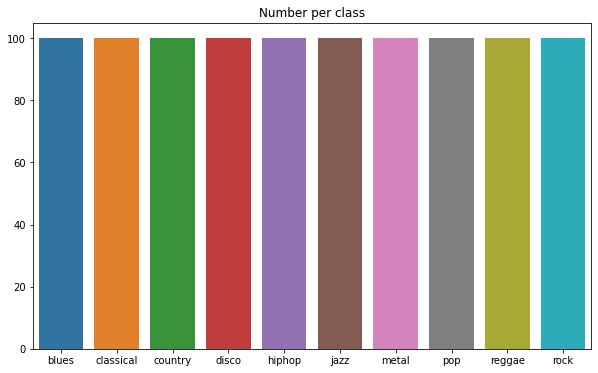

In [12]:
# 예측해야할 클래스

class_count = df['label'].value_counts()
plt.figure(figsize=(10,6))
plt.title('Number per class')
_=sns.barplot(x=class_count.index, y=class_count.values)

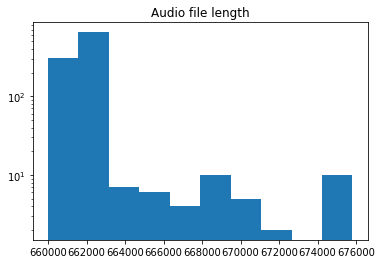

In [13]:
# 음성 파일의 길이
plt.title('Audio file length')
_=plt.hist(df['length'], log=True)

In [14]:
# 특성 분포
print(df.columns[2:-1])
print('특성 개수', len(df.columns[2:-1]))

Index(['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var'],
      dtype='object')
특

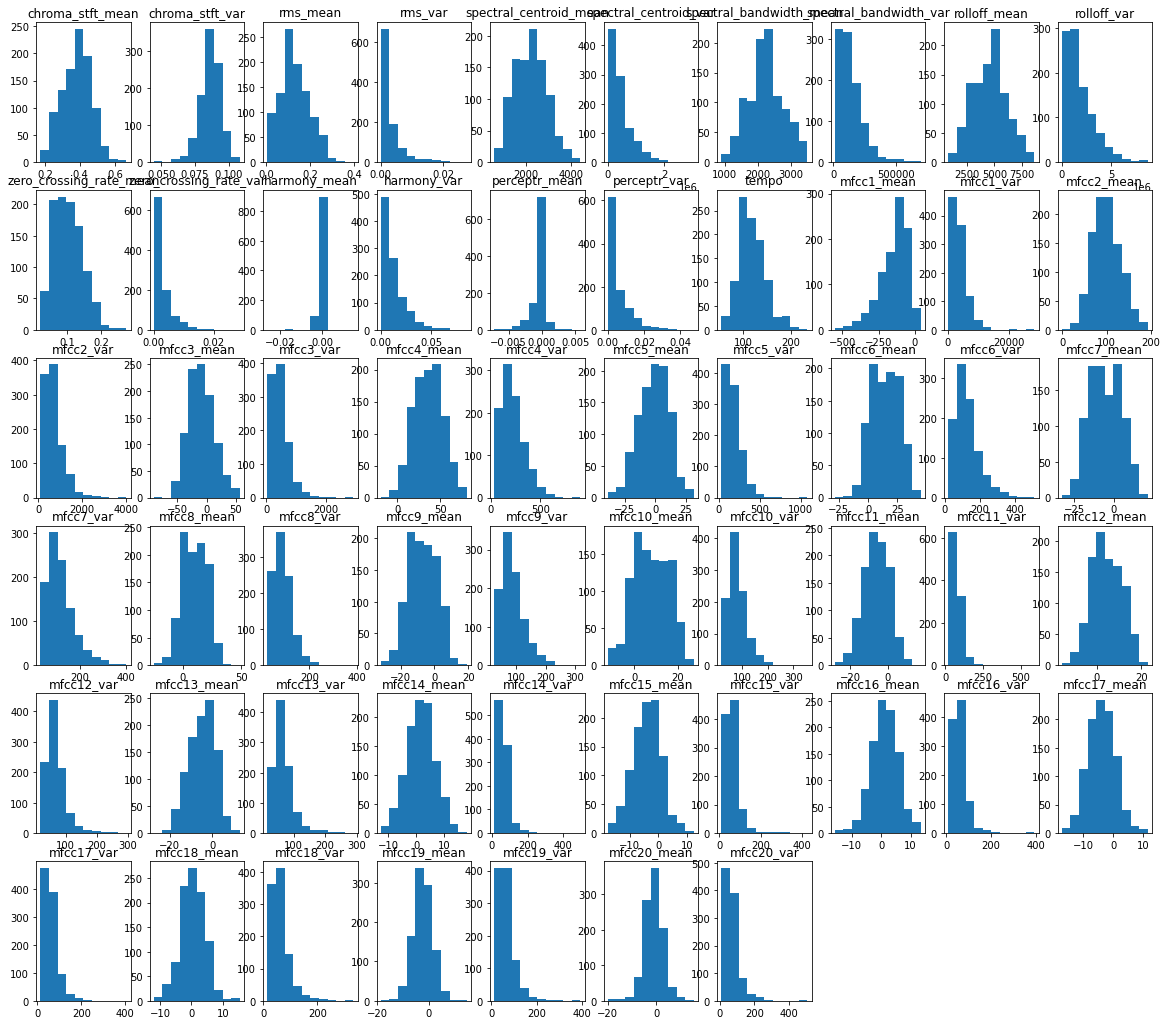

In [15]:
plt.figure(figsize=(20,18))
for i, col in enumerate(df.columns[2:-1]):
  plt.subplot(6,10, i+1)
  plt.title(col)
  plt.hist(df[col])

## 머신러닝 접근 방법 (features)
---

### **| 파라미터 추가**


In [ ]:
import librosa
# 데이터/장르_original/각 클래스별/wav읽기

new_arr = np.zeros([1000, 8])

for i, (f_name, label) in enumerate(zip(df['filename'], df['label'])):
  if i%10==0:print(f'*{i}')
  if f_name =='jazz.00054.wav' : continue
  dir_path = f'/content/Data/genres_original/{label}/'
  f_path = f'{dir_path}/{f_name}'
  # f_path로 부터 wav데이터 읽기
  y, sr = librosa.load(f_path) # 데이터는 1차원 배열 형태임 sr은 16만개
  # zazz 0054데이터 오류
  # 읽어낸 데이터에서 feature 추출 
  chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
  spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
  spectral_flatness = librosa.feature.spectral_flatness(y=y)
  tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

  chroma_cens_mean = np.mean(chroma_cens)
  chroma_cens_var = np.var(chroma_cens)

  spectral_centroid_mean = np.mean(spectral_centroid)
  spectral_centroid_var = np.var(spectral_centroid)

  spectral_flatness_mean = np.mean(spectral_flatness)
  spectral_flatness_var = np.var(spectral_flatness)

  tonnetz_mean = np.mean(tonnetz)
  tonnetz_var = np.var(tonnetz)

  new_arr[i, 0] = chroma_cens_mean
  new_arr[i, 1] = chroma_cens_var
  new_arr[i, 2] = spectral_centroid_mean
  new_arr[i, 3] = spectral_centroid_var
  new_arr[i, 4] = spectral_flatness_mean
  new_arr[i, 5] = spectral_flatness_var
  new_arr[i, 6] = tonnetz_mean
  new_arr[i, 7] = tonnetz_var

new_arr.shape

*0
*10
*20
*30
*40
*50
*60
*70
*80
*90
*100
*110
*120
*130
*140
*150
*160
*170
*180
*190
*200
*210
*220
*230
*240
*250
*260
*270
*280
*290
*300
*310
*320
*330
*340
*350
*360
*370
*380
*390
*400
*410
*420
*430
*440
*450
*460
*470
*480
*490
*500
*510
*520
*530
*540
*550
*560
*570
*580
*590
*600
*610
*620
*630
*640
*650
*660
*670
*680
*690
*700
*710
*720
*730
*740
*750
*760
*770
*780
*790
*800
*810
*820
*830
*840
*850
*860
*870
*880
*890
*900
*910
*920
*930
*940
*950
*960
*970
*980
*990


(1000, 8)

In [ ]:
df.shape, new_arr.shape

((1000, 60), (1000, 8))

In [ ]:
 df['chroma_cens_mean'] = new_arr[:,0]
 df['chroma_cens_var'] = new_arr[:,1]
 df['spectral_centroid_mean'] = new_arr[:,2]
 df['spectral_centroid_var'] = new_arr[:,3]
 df['spectral_flatness_mean'] = new_arr[:,4]
 df['spectral_flatness_var'] = new_arr[:,5]
 df['tonnetz_mean'] = new_arr[:,6]
 df['tonnetz_var'] = new_arr[:,7]

In [ ]:
# 추가된 데이터로 전처리
  # 데이터 하나 빼기(데이터 프레임에서 한줄 제거(jazz00054))
print(df[df['filename']=='jazz.00054.wav'].index)
df = df.drop(df.index[554])

Int64Index([554], dtype='int64')


In [ ]:
#추가된 데이터로 머신러닝 돌리기
  # pycarat


# 추가된 데이터 딥러닝 돌리기

### **| 전처리**


In [ ]:
# label encoding ( blues, classical,.....) - > (0, 1,.....)
from sklearn import preprocessing

le= preprocessing.LabelEncoder()
df['le_label'] = le.fit_transform(df['label'])
print(le.classes_)
df.head()

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc20_mean,mfcc20_var,label,chroma_cens_mean,chroma_cens_var,spectral_flatness_mean,spectral_flatness_var,tonnetz_mean,tonnetz_var,le_label
0,blues.00000.wav,661794,-0.351458,0.312112,-0.010206,-0.061909,-0.584198,-0.848543,-0.456442,-0.530293,...,0.603680,-0.512168,blues,0.898202,-0.931015,-0.591810,-0.361414,-0.091326,-0.708647,0
1,blues.00001.wav,661794,-0.463832,1.116740,-0.532167,-0.186812,-0.939049,-0.234646,-0.386924,0.796552,...,0.423832,-0.537595,blues,0.459266,-0.439517,-0.668073,-0.363283,0.799266,-0.683904,0
2,blues.00002.wav,661794,-0.185503,-0.137977,0.680195,-0.084135,-0.907425,-0.781949,-0.940476,-0.630133,...,-0.296126,-0.874037,blues,0.524649,-0.511437,-0.656524,-0.366653,0.601229,-0.271520,0
3,blues.00003.wav,661794,0.318490,0.989883,0.155230,0.906495,-1.581818,-0.712375,-1.227934,0.305031,...,-0.602666,-0.843600,blues,-0.914252,0.966744,-0.714637,-0.368981,0.694288,0.255240,0
4,blues.00004.wav,661794,-0.860529,0.193740,-0.599454,-0.205890,-0.513171,-0.315600,-0.939583,-0.503723,...,-2.764719,-0.329516,blues,0.402483,-0.377425,-0.635494,-0.364528,-1.228504,-0.299223,0


In [ ]:
selected = [ 'chroma_stft_mean',
 'chroma_stft_var',
 'rms_mean',
 'rms_var',
 'spectral_centroid_mean',
 'spectral_centroid_var',
 'spectral_bandwidth_mean',
 'spectral_bandwidth_var',
 'rolloff_mean',
 'rolloff_var',
 'zero_crossing_rate_mean',
 'zero_crossing_rate_var',
 'harmony_mean',
 'harmony_var',
 'perceptr_mean',
 'perceptr_var',
 'tempo',
 'mfcc1_mean',
 'mfcc1_var',
 'mfcc2_mean',
 'mfcc2_var',
 'mfcc3_mean',
 'mfcc3_var',
 'mfcc4_mean',
 'mfcc4_var',
 'mfcc5_mean',
 'mfcc5_var',
 'mfcc6_mean',
 'mfcc6_var',
 'mfcc7_mean',
 'mfcc7_var',
 'mfcc8_mean',
 'mfcc8_var',
 'mfcc9_mean',
 'mfcc9_var',
 'mfcc10_mean',
 'mfcc10_var',
 'mfcc11_mean',
 'mfcc11_var',
 'mfcc12_mean',
 'mfcc12_var',
 'mfcc13_mean',
 'mfcc13_var',
 'mfcc14_mean',
 'mfcc14_var',
 'mfcc15_mean',
 'mfcc15_var',
 'mfcc16_mean',
 'mfcc16_var',
 'mfcc17_mean',
 'mfcc17_var',
 'mfcc18_mean',
 'mfcc18_var',
 'mfcc19_mean',
 'mfcc19_var',
 'mfcc20_mean',
 'mfcc20_var',
 'chroma_cens_mean',
 'chroma_cens_var',
 'spectral_flatness_mean',
 'spectral_flatness_var',
 'tonnetz_mean',
 'tonnetz_var']

In [ ]:
# x 정규화
sc = preprocessing.StandardScaler() # 스탠다드 0-1 사이
df[selected] = sc.fit_transform(df[selected])

In [ ]:
!pip install pycaret
!pip install Jinja2==3.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 4.0 MB/s 
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.0.1
    Uninstalling Jinja2-3.0.1:
      Successfully uninstalled Jinja2-3.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Jinja2-3.0.1-py3-none-any.whl (133 kB)
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.0.1 which is incompatible.


In [ ]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [ ]:
from pycaret.regression import *

In [ ]:
df_train = df[selected+['le_label']].iloc[:799]
x = df_train[selected]
y = df_train['le_label']
X_test = df[selected].iloc[799:]
x.shape, y.shape

((799, 63), (799,))

In [ ]:
df_train.shape, X_test.shape

((799, 64), (200, 63))

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 799
Data columns (total 64 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   chroma_stft_mean         799 non-null    float64
 1   chroma_stft_var          799 non-null    float64
 2   rms_mean                 799 non-null    float64
 3   rms_var                  799 non-null    float64
 4   spectral_centroid_mean   799 non-null    float64
 5   spectral_centroid_var    799 non-null    float64
 6   spectral_bandwidth_mean  799 non-null    float64
 7   spectral_bandwidth_var   799 non-null    float64
 8   rolloff_mean             799 non-null    float64
 9   rolloff_var              799 non-null    float64
 10  zero_crossing_rate_mean  799 non-null    float64
 11  zero_crossing_rate_var   799 non-null    float64
 12  harmony_mean             799 non-null    float64
 13  harmony_var              799 non-null    float64
 14  perceptr_mean            7

In [ ]:
data = setup(data=df_train, target='le_label', train_size=0.8)

,Description,Value
0,session_id,638
1,Target,le_label
2,Original Data,"(799, 64)"
3,Missing Values,False
4,Numeric Features,63
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(639, 62)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='le_label',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strateg...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
              

In [ ]:
compare_models(sort='RMSLE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,0.2993,0.2154,0.4590,0.6631,0.2088,0.7663,0.067
xgboost,Extreme Gradient Boosting,0.3462,0.2358,0.4820,0.6279,0.2276,0.8164,1.043
lightgbm,Light Gradient Boosting Machine,0.3418,0.2144,0.4612,0.6626,0.2306,0.7879,0.455
et,Extra Trees Regressor,0.3505,0.2155,0.4627,0.6621,0.2321,0.7718,0.663
rf,Random Forest Regressor,0.3734,0.2330,0.4814,0.6343,0.2374,0.8825,1.402
gbr,Gradient Boosting Regressor,0.3823,0.2495,0.4986,0.6083,0.2463,0.8742,0.792
dt,Decision Tree Regressor,0.3596,0.4267,0.6495,0.3295,0.2538,0.8606,0.036
lr,Linear Regression,0.4848,0.3539,0.5939,0.4397,0.2893,1.0822,0.535
ridge,Ridge Regression,0.4880,0.3544,0.5945,0.4390,0.2913,1.0936,0.019
huber,Huber Regressor,0.4820,0.3675,0.6047,0.4203,0.2931,1.0584,0.070


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 2
INFO:logs:KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                    weights='uniform')
INFO:logs:compare_models() succesfully completed......................................


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
knn = create_model('knn')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2914,0.2228,0.4720,0.6535,0.2421,0.9238
1,0.3512,0.2691,0.5187,0.6257,0.2298,0.6912
2,0.2947,0.1897,0.4356,0.6624,0.2178,0.8486
3,0.1936,0.0881,0.2968,0.8409,0.1361,0.6457
4,0.3360,0.2916,0.5400,0.5840,0.2101,0.8358
5,0.3556,0.2850,0.5338,0.4833,0.2173,0.8713
6,0.3186,0.2046,0.4523,0.6546,0.2031,0.8099
7,0.2893,0.1800,0.4242,0.6989,0.1893,0.7761
8,0.2936,0.2519,0.5019,0.6652,0.2165,0.6356


INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 3
INFO:logs:KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                    weights='uniform')
INFO:logs:create_model() succesfully completed......................................


In [ ]:
knn_tuned = tune_model(knn, optimize='RMSLE')
knn_tuned

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2954,0.2187,0.4677,0.6599,0.2398,0.8805
1,0.3420,0.2669,0.5166,0.6288,0.2234,0.6571
2,0.3019,0.1824,0.4271,0.6754,0.2126,0.8444
3,0.2146,0.1000,0.3162,0.8194,0.1546,0.7205
4,0.3314,0.2950,0.5431,0.5791,0.2179,0.8239
5,0.3573,0.2944,0.5426,0.4661,0.2215,0.8470
6,0.3338,0.2133,0.4618,0.6399,0.1979,0.8730
7,0.2924,0.1775,0.4213,0.7031,0.1805,0.7770
8,0.2946,0.2435,0.4935,0.6763,0.1983,0.5794


INFO:logs:create_model_container: 21
INFO:logs:master_model_container: 21
INFO:logs:display_container: 4
INFO:logs:KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
                    metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
                    weights='distance')
INFO:logs:tune_model() succesfully completed......................................


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
                    metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
                    weights='distance')

In [ ]:
# 앙상블
blender = blend_models(estimator_list=compare_models(n_select=3,
                                                     sort='RMSLE'))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2953,0.1783,0.4223,0.7227,0.2219,0.8615
1,0.3162,0.1756,0.4190,0.7558,0.2265,0.5775
2,0.3264,0.1909,0.4369,0.6603,0.2211,0.8321
3,0.2385,0.1033,0.3214,0.8135,0.1613,0.7119
4,0.2980,0.1988,0.4459,0.7163,0.2250,0.7613
5,0.3569,0.2410,0.4909,0.5629,0.2395,0.8089
6,0.3473,0.2013,0.4487,0.6601,0.2182,0.9141
7,0.2919,0.1606,0.4008,0.7313,0.1958,0.6802
8,0.3190,0.2319,0.4815,0.6918,0.2038,0.6000


INFO:logs:create_model_container: 41
INFO:logs:master_model_container: 41
INFO:logs:display_container: 6
INFO:logs:VotingRegressor(estimators=[('knn',
                             KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                                 metric='minkowski',
                                                 metric_params=None, n_jobs=-1,
                                                 n_neighbors=5, p=2,
                                                 weights='uniform')),
                            ('xgboost',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=Fals...
                      

In [ ]:
# 최종 모델
final_model = finalize_model(blender)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingRegressor(estimators=[('knn',
                             KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                                 metric='minkowski',
                                                 metric_params=None, n_jobs=-1,
                                                 n_neighbors=5, p=2,
                                                 weights='uniform')),
                            ('xgboost',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=Fals...
                                           colsample_bytree=1.

In [ ]:
# 예측
y_pred=predict_model(final_model, data=X_test)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=VotingRegressor(estimators=[('knn',
                             KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                                 metric='minkowski',
                                                 metric_params=None, n_jobs=-1,
                                                 n_neighbors=5, p=2,
                                                 weights='uniform')),
                            ('xgboost',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=Fals...
                                           colsample_bytree=1.0,

### **| 학습 - XGBoost**

In [ ]:
from sklearn import preprocessing

le= preprocessing.LabelEncoder()
df['le_label'] = le.fit_transform(df['label'])
print(le.classes_)
df.head()

In [ ]:
x = df.drop(columns=['filename','length','label','le_label'])
y = df['le_label']
x.shape, y.shape

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=0)
print('train', x_train.shape, y_train.shape)
print('test', x_test.shape, y_test.shape)

In [ ]:
sc = preprocessing.StandardScaler() # 스탠다드 0-1 사이
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
! pip install xgboost -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 41 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=1000)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
def show_result(model, x_test, y_test, proba=False):
  y_pred = model.predict(x_test)
  if proba:
    y_pred= np.argmax(y_pred, axis=1)
  print('Test Acc:', accuracy_score(y_test, y_pred))
  #print(classification_report(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  _=sns.heatmap(cm, annot=True, cmap='PuBu', xticklabels=le.classes_, yticklabels=le.classes_)
show_result(xgb, x_test, y_test)

### **| 학습 - DNN**

In [ ]:
# 딥러닝
def build_model():
  x = layers.Input(63,)
  z = layers.Dense(128, activation='relu')(x)
  z = layers.Dense(64, activation='relu')(z)
  y = layers.Dense(10, activation='softmax')(z)
  model = models.Model(x, y)
  return model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 63)]              0         
                                                                 
 dense_3 (Dense)             (None, 128)               8192      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 17,098
Trainable params: 17,098
Non-trainable params: 0
_________________________________________________________________


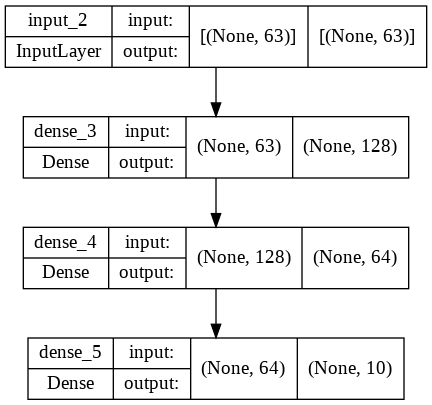

In [ ]:
model = build_model()
model.summary()
utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
# 딥러닝
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df[selected], df['le_label'], test_size=0.1, stratify=y, random_state=0)
print('train', x_train.shape, y_train.shape)
print('test', x_test.shape, y_test.shape)

train (899, 63) (899,)
test (100, 63) (100,)


In [ ]:
model.fit(x_train, y_train, epochs=30, batch_size=8)

Epoch 1/30
113/113 [==============================] - 99s 3ms/step - loss: 1.7697 - accuracy: 0.3893
Epoch 2/30
113/113 [==============================] - 0s 3ms/step - loss: 1.0659 - accuracy: 0.6440
Epoch 3/30
113/113 [==============================] - 0s 3ms/step - loss: 0.8034 - accuracy: 0.7475
Epoch 4/30
113/113 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.8076
Epoch 5/30
113/113 [==============================] - 0s 3ms/step - loss: 0.5285 - accuracy: 0.8465
Epoch 6/30
113/113 [==============================] - 0s 3ms/step - loss: 0.4382 - accuracy: 0.8977
Epoch 7/30
113/113 [==============================] - 0s 3ms/step - loss: 0.3647 - accuracy: 0.8954
Epoch 8/30
113/113 [==============================] - 0s 3ms/step - loss: 0.3218 - accuracy: 0.9110
Epoch 9/30
113/113 [==============================] - 0s 3ms/step - loss: 0.2588 - accuracy: 0.9388
Epoch 10/30
113/113 [==============================] - 0s 3ms/step - loss: 0.2233 - accuracy: 0.953

In [ ]:
show_result(model, x_test, y_test, proba=True)

NameError: ignored

## 딥러닝 접근 방법(Audio 원 데이터)
---

In [43]:
csv_path = '/content/Data/features_30_sec.csv'
data_dir = '/content/Data/genres_original'
class_dict = {
    'blues':0,
    'classical':1,
    'country':2,
    'disco':3,
    'hiphop':4,
    'jazz':5,
    'metal':6,
    'pop':7,
    'reggae':8,
    'rock':9
}

def df_process(csv_path, data_dir, class_dict):
  df = pd.read_csv(csv_path)
  df = df.drop(df.index[554])
# 파일이름을 경로로 설정
  df['filepath'] = df.apply( lambda x : f'{data_dir}/{x["label"]}/{x["filename"]}', axis=1)
# 라벨인코딩
  df['label'] = df['label'].map(class_dict)
  return list(df['filepath']), list(df['label'])

paths, labels = df_process(csv_path, data_dir, class_dict)

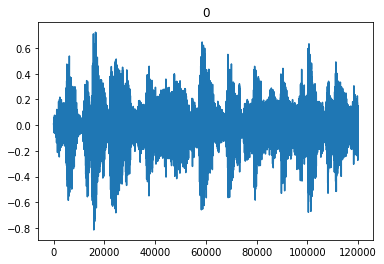

In [44]:
def path2wav(path, label, mx_len=120000):
  f = tf.io.read_file(path)
  wav, sr = tf.audio.decode_wav(f, desired_channels=1)
  wav= tf.squeeze(wav, axis=-1)  # 차원 축소 squeeze
  wav= wav[:mx_len]
  return wav, label

wav, label = path2wav(paths[0], labels[0])
plt.title(label)
plt.plot(wav)

from IPython import display
display.Audio(wav, rate=16000)

In [45]:
import tensorflow_hub as hub
# 텐서플로우 허브 모델 사용(전이학습)

# Load the model.
yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

In [47]:
# 텐서플로우 텐서 슬라이스

def wav2embedding(wav, label):
  _, embedding, _ = yamnet(wav)
  return embedding, label

def ds_generator(paths, labels, batch_size=10, train=True): 
  ds = tf.data.Dataset.from_tensor_slices((  paths, labels)  )
  ds = ds.map(path2wav)
  ds = ds.map(wav2embedding)
  if train:
    ds = ds.shuffle(buffer_size=1000)
  ds = ds.cache().prefetch(tf.data.AUTOTUNE)
  ds = ds.batch(batch_size)
  return ds


from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(paths, labels, test_size=0.1, stratify=labels, random_state=0)

print('train', len(train_paths), len(train_labels))
print('test', len(test_paths), len(test_labels))

train_ds = ds_generator(train_paths, train_labels)
test_ds = ds_generator(test_paths, test_labels, train=False)

train 899 899
test 100 100


In [49]:
for embeddings, labels in train_ds.take(1):
  print(embeddings.shape, labels)

(10, 15, 1024) tf.Tensor([6 2 1 1 4 4 6 5 7 7], shape=(10,), dtype=int32)


In [54]:

def create_wavenet_base(x_shape, y_shape):
  model = models.Sequential()
  model.add(layers.Input(shape=x_shape))

  for rate in (1, 2, 4, 8):
    model.add(layers.Conv1D(20, kernel_size=2, activation='relu', padding='causal', dilation_rate=rate))
    
    model.add(layers.AveragePooling1D(100, padding='same'))
    model.add(layers.Conv1D(10, 1, padding='same', activation='relu'))
    model.add(layers.AveragePooling1D(100, padding='same'))
    model.add(layers.Conv1D(10, 1, padding='same', activation='relu'))
    model.add(layers.Reshape(  (120,))  )
    model.add(layers.Dense(10, activation='softmax'))
  
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])

    return model

def create_yamnet_base(x_shape, y_shape):
  model = models.Sequential()
  model.add(layers.Input(shape=x_shape))

  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dropout(0.5))

  model.add(layers.Reshape(  (int(15*32), )  ))
  model.add(layers.Dense(10, activation='softmax'))

  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

  return model

#x_shape = (120000, 1)
x_shape = (15, 1024)
y_shape = (10)

model = create_yamnet_base(x_shape, y_shape)
model.summary()



Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 15, 32)            32800     
                                                                 
 dropout_1 (Dropout)         (None, 15, 32)            0         
                                                                 
 reshape_3 (Reshape)         (None, 480)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                4810      
                                                                 
Total params: 37,610
Trainable params: 37,610
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.fit(train_ds, epochs=100, validation_data=test_ds)

Epoch 1/100
90/90 [==============================] - 102s 124ms/step - loss: 1.8481 - acc: 0.3382 - val_loss: 1.1551 - val_acc: 0.5700
Epoch 2/100
90/90 [==============================] - 0s 5ms/step - loss: 1.0863 - acc: 0.6229 - val_loss: 0.9136 - val_acc: 0.6500
Epoch 3/100
90/90 [==============================] - 0s 5ms/step - loss: 0.8611 - acc: 0.6941 - val_loss: 0.8264 - val_acc: 0.6700
Epoch 4/100
90/90 [==============================] - 0s 5ms/step - loss: 0.7244 - acc: 0.7542 - val_loss: 0.7742 - val_acc: 0.6700
Epoch 5/100
90/90 [==============================] - 0s 5ms/step - loss: 0.6785 - acc: 0.7675 - val_loss: 0.7455 - val_acc: 0.7000
Epoch 6/100
90/90 [==============================] - 0s 5ms/step - loss: 0.6030 - acc: 0.7920 - val_loss: 0.7536 - val_acc: 0.6900
Epoch 7/100
90/90 [==============================] - 0s 5ms/step - loss: 0.5464 - acc: 0.7964 - val_loss: 0.7296 - val_acc: 0.7400
Epoch 8/100
90/90 [==============================] - 0s 5ms/step - loss: 0.4707

In [ ]:
# 머신러닝 vs 딥러닝

# 딥러닝이 학습 잘 되려면

# 1. 데이터의 개수
# 2. 인풋 피쳐의 dimension이 클수록 데이터 개수가 더필요하다.


# 데이터 증강
# 전이학습


